# Bayesian analysis of the second MTurk Experiment (Feb. 2019)

The goal is to use an ANOVA / ANCOVA style analysis for the experiments; it is possible that the metadata collected (income, education level) play a moderating role. A weakness is that since these are self reported, they may contain substantial noise.

In [40]:
# %load std_ipython_import.txt
import pandas as pd
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import seaborn as sb
import pymc3 as pm

import theano.tensor as tt
from theano.compile.ops import as_op

from scipy.stats import norm
from scipy.stats import t as studentT
from scipy import linalg, sparse, stats

from matplotlib import gridspec
from matplotlib.patches import Rectangle
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

from IPython.display import Image

%matplotlib inline
plt.style.use('seaborn-white')
color = '#87ceeb'

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

from matplotlib import rc
# # Use LaTeX for typesetting
# rc('text', usetex=True)
# # Use ACM standard fonts (Type 1) for numbers and labels
# rc('text.latex',
#    preamble=[
#        r'\usepackage[tt=false, type1=true]{libertine}',
#        r'\usepackage[libertine]{newtxmath}', r'\usepackage[varqu]{zi4}',
#        r'\usepackage[T1]{fontenc}'
#    ])

# Data

In [41]:
# Using dtype 'category' for Y

df = pd.read_csv(
    'data/cs_final.csv'
    #     dtype={
    #         'y': 'int',
    #         'gesture': 'int',
    #         'dist': 'int',
    #         'shading': 'int',
    #         'cond': 'int',
    #         'comicleft': 'int'
    #     }
)

df.rename(
    columns={
        'Q9': 'education',
        'Q8': 'income',
        'Q7': 'gender',
        'text_donation': 'text',
        'comic_donation': 'comic',
        'socialnorm_donation': 'social'
    },
    inplace=True)
# df.info()
dfs = pd.DataFrame()

In [42]:
# adding the response and condition columns
df['condition'] = 0
df.loc[df.text>=0, ['condition']] = "text"
df.loc[df.social>=0, ['condition']] = "comic+social"
df.loc[df.comic>=0, ['condition']] = "comic"

df['response'] = 0
df.loc[df.text>=0, ['response']] = df.text[df.text>=0]
df.loc[df.social>=0, ['response']] = df.social[df.social>=0]
df.loc[df.comic>=0, ['response']] = df.comic[df.comic>=0]

## helper functions from DBDA-Python

https://github.com/JWarmenhoven/DBDA-python

In [43]:
# Calculate Gamma shape and rate from mode and sd.
# if using gamma prior for the class dependent sigma


def gammaShRaFromModeSD(mode, sd):
    rate = (mode + np.sqrt(mode**2 + 4 * sd**2)) / (2 * sd**2)
    shape = 1 + mode * rate
    return (shape, rate)

In [44]:
def plot_mustache(var, sd, j, axis, width=.75):
    for i in np.arange(start=0, stop=len(var), step=int(len(var) * .1)):
        rv = norm(loc=var[i], scale=sd[i])
        yrange = np.linspace(rv.ppf(0.01), rv.ppf(0.99), 100)
        xrange = rv.pdf(yrange)

        # When the SD of a group is large compared to others, then the top of its mustache is relatively
        # low and does not plot well together with low SD groups.
        # Scale the xrange so that the 'height' of the all mustaches is 0.75
        xrange_scaled = xrange * (width / xrange.max())

        # Using the negative value to flip the mustache in the right direction.
        axis.plot(-xrange_scaled + j, yrange, color=color, alpha=.6)

In [67]:
# minor tweak to the plotting function to accomodate the student T

def plot_mustache_studentT(var, sd, j, degree_f, axis, width=.75):
    for i in np.arange(start=0, stop=len(var), step=int(len(var) * .05)):
        rv = studentT(loc=var[i], scale=sd[i], df=degree_f[i])
        yrange = np.linspace(rv.ppf(0.01), rv.ppf(0.99), 100)
        xrange = rv.pdf(yrange)

        # When the SD of a group is large compared to others, then the top of its mustache is relatively
        # low and does not plot well together with low SD groups.
        # Scale the xrange so that the 'height' of the all mustaches is 0.75
        xrange_scaled = xrange * (width / xrange.max())

        # Using the negative value to flip the mustache in the right direction.
        axis.plot(-xrange_scaled + j, yrange, color=color, alpha=.6)

In [46]:
def plot_cred_lines(b0, bj, bcov, x, ax):
    """Plot credible posterior distribution lines for model in section 19.4"""

    B = pd.DataFrame(
        np.c_[b0, bj, bcov], columns=['beta0', 'betaj', 'betacov'])

    # Credible posterior prediction lines
    hpd_interval = pm.hpd(B.values, alpha=0.05)
    B_hpd = B[B.beta0.between(*hpd_interval[0, :])
              & B.betaj.between(*hpd_interval[1, :]) &
              B.betacov.between(*hpd_interval[2, :])]
    xrange = np.linspace(x.min() * .95, x.max() * 1.05)

    for i in np.random.randint(0, len(B_hpd), 10):
        ax.plot(
            xrange,
            B_hpd.iloc[i, 0] + B_hpd.iloc[i, 1] + B_hpd.iloc[i, 2] * xrange,
            c=color,
            alpha=.6,
            zorder=0)

## back to our analysis

In [47]:
# doing all three cases together
m_mean = np.zeros(3)
m_mean[0] = np.mean(df[df.condition=="text"].response)
m_mean[1] = np.mean(df[df.condition=="comic"].response)
m_mean[2] = np.mean(df[df.condition=="comic+social"].response)

m_std = np.zeros(3)
m_std[0] = np.std(df[df.condition=="text"].response)
m_std[1] = np.std(df[df.condition=="comic"].response)
m_std[2] = np.std(df[df.condition=="comic+social"].response)

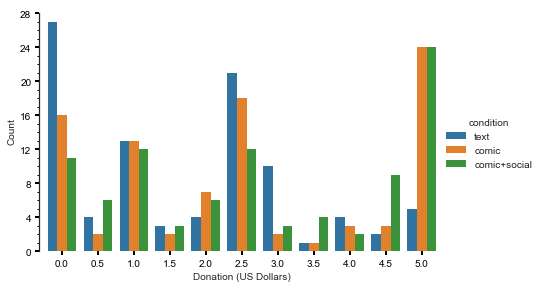

In [48]:
g = sb.catplot(
    hue="condition",
    data=df,
    hue_order=["text", "comic", "comic+social"],
    height=4,
    x="response",
    kind="count",
    aspect=1.5).set(yticks=np.arange(0, 30, 4)).set_axis_labels(
        "Donation (US Dollars)", "Count")

# custom limits requires us to tell where the majot and minor ticks are
majorLocator = MultipleLocator(4) 
minorLocator = MultipleLocator(2)

g.ax.yaxis.set_major_locator(majorLocator)
g.ax.yaxis.set_minor_locator(minorLocator)

g.ax.tick_params(direction='out', length=4, width=2, colors='k', which='major')
g.ax.tick_params(
    direction='out', length=2, width=1, colors='k', which='minor', bottom=False)
g.ax.minorticks_on()
g.despine(offset=5, left=False, bottom=True, trim=True)
g.savefig("contributions across conditions.pdf")

## Defining the model

We have three different groups, who are randomly assigned to text, comic, comic+social conditions. The outcome variable is the degree of contribution. Thus, we have an ANOVA style situation, where we have a metric predicted variable, with a nominal (i.e. the group index) predictor.

We model it as a student-t distribution; the number of degrees of freedom is obtained from an exponential distribution $\nu \sim \exp(-\lambda)$; the mode $\mu \sim \mathcal{N}(a,b)$, spread $\sigma \sim U(L,H)$



In [49]:
# Count the number of records per nominal group
df['condition'] = df['condition'].astype('category')
df.condition.value_counts()

text            94
comic+social    92
comic           91
Name: condition, dtype: int64

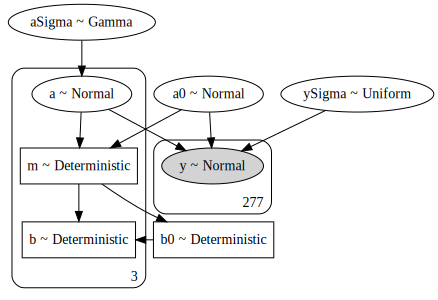

In [10]:
x = df.condition.cat.codes.values
y = df.response

yMean = y.mean()
ySD = y.std()

NxLvl = len(df.condition.cat.categories) # number of groups
agammaShRa = gammaShRaFromModeSD(ySD/2, 2*ySD)

# this model assumes normality
with pm.Model() as model1:
    
    aSigma = pm.Gamma('aSigma', agammaShRa[0], agammaShRa[1])
    a0 = pm.Normal('a0', yMean, tau=1/(ySD*5)**2)
    a = pm.Normal('a', 0.0, tau=1/aSigma**2, shape=NxLvl)
       
    ySigma = pm.Uniform('ySigma', ySD/100, ySD*10)
    y = pm.Normal('y', a0 + a[x], tau=1/ySigma**2, observed=y)
    
    # Convert a0,a to sum-to-zero b0,b 
    m = pm.Deterministic('m', a0 + a)
    b0 = pm.Deterministic('b0', tt.mean(m))
    b = pm.Deterministic('b', m - b0) 
    
pm.model_to_graphviz(model1)

In [11]:
with model1:
    trace1 = pm.sample(5000,nuts_kwargs={'target_accept': 0.95})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ySigma, a, a0, aSigma]
Sampling 4 chains: 100%|██████████| 22000/22000 [00:37<00:00, 579.56draws/s]
The acceptance probability does not match the target. It is 0.8810983910192344, but should be close to 0.95. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.


In [12]:
print(pm.diagnostics.gelman_rubin(trace1))
print("effective sample size", pm.diagnostics.effective_n(trace1))

{'a0': 1.0006577999005732, 'a': array([1.00059529, 1.00051329, 1.00056718]), 'aSigma': 1.0002711595624425, 'ySigma': 1.0001059531495353, 'm': array([1.00016714, 1.00011371, 0.99996557]), 'b0': 1.0002009624516555, 'b': array([1.00010137, 0.99998606, 0.99998113])}
effective sample size {'a0': 1438.257930969411, 'a': array([1454.66846717, 1454.63370682, 1458.69291473]), 'aSigma': 2687.760512315697, 'ySigma': 11126.403928625501, 'm': array([22885.68780048, 19001.34010033, 18242.93148403]), 'b0': 20916.506155545765, 'b': array([24927.17482977, 18672.74418611, 16626.93750033])}


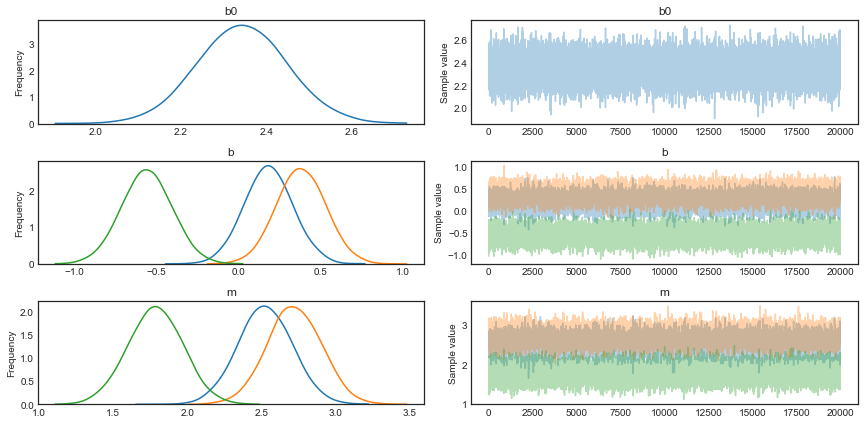

In [13]:
pm.traceplot(trace1, varnames=['b0', 'b', 'm'], combined=True);

## analysing the model parameters

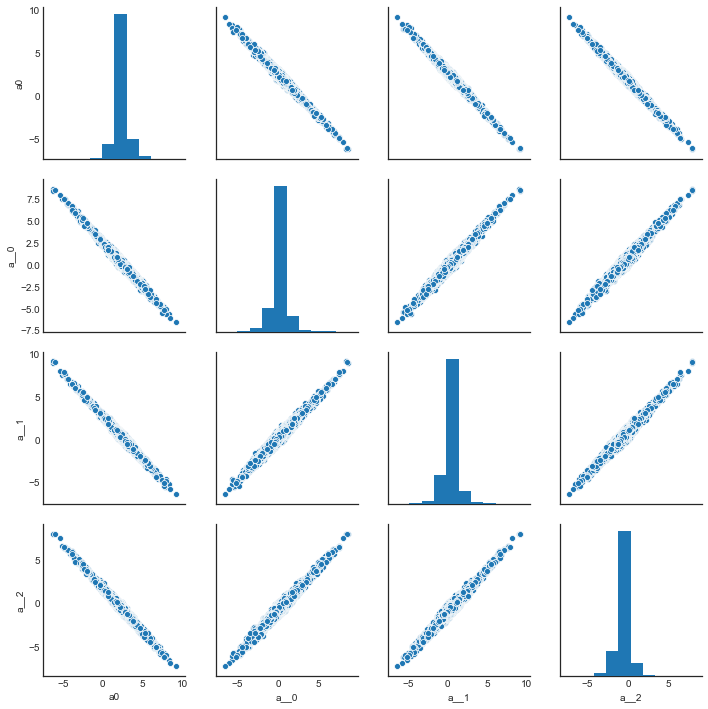

In [14]:
tracedf1 = pm.trace_to_dataframe(trace1, varnames=['a0', 'a'])
sb.pairplot(tracedf1);

In [15]:
vals = np.array([model1.dict_to_array(v) for v in trace1[1000:]]).T
vals[:] -= vals.mean(axis=1)[:, None]
vals[:] /= vals.std(axis=1)[:, None]

U, S, Vh = linalg.svd(vals)

In [16]:
len(S)

6

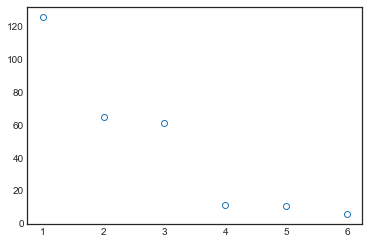

In [17]:
sb.mpl.pyplot.plot(np.arange(1, len(S)+1), S, 'o', mfc='w', mew=1)

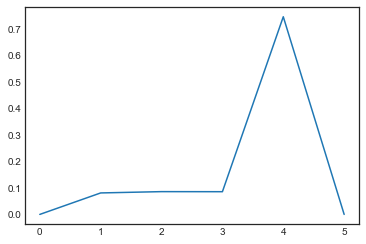

In [18]:
plt.plot(U[:, -1] ** 2)


In [92]:
# Here we plot the metric predicted variable for each group. Then we superimpose the
# posterior predictive distribution

comic = trace1['m'][:, 0]
social = trace1['m'][:, 1]
text = trace1['m'][:, 2]
scale = trace1['ySigma'][:]

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.set_title('Data with Posterior Predictive Distribution')

# sb.violinplot(
#     'condition',
#     'response',
#     split=True,
#     data=df,
#     order=["text","comic", "comic+social"],
#     inner=None,
#     ax=ax)

sb.swarmplot(
    'condition',
    'response',
    data=df,
    order=["text","comic", "comic+social"],
#     color="white",
#     edgecolor="gray",
    ax=ax)
ax.set_xlim(xmin=-1)

for i, grp in enumerate([text, comic, social]):
    plot_mustache(grp, scale, i, ax)

z = ax
z.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
z.tick_params(direction='in', length=6, width=2, colors='k', which='major')
z.tick_params(
    direction='in', length=4, width=1, colors='k', which='minor', bottom=False)
z.yaxis.set_ticks_position('left')
z.spines['right'].set_visible(False)
z.spines['top'].set_visible(False)
z.spines['left'].set_visible(False)
z.spines['bottom'].set_visible(False)
z.spines['bottom'].set_position(('outward', 10))

z.minorticks_on()

fig.savefig("data, with basic ANOVA-like posterior predictions.pdf")

NameError: name 'trace1' is not defined

## contrasts

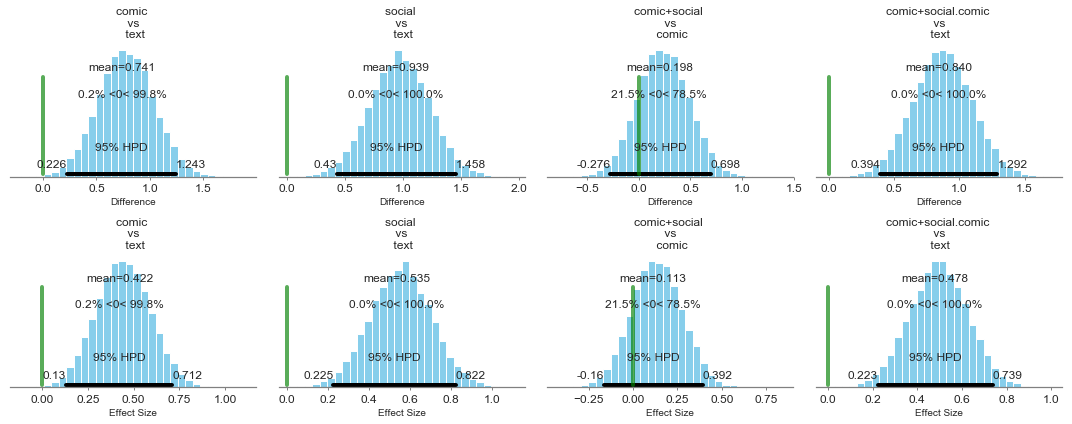

In [20]:
# # Use LaTeX for typesetting
# rc('text', usetex=True)
# # Use ACM standard fonts (Type 1) for numbers and labels
# rc('text.latex',
#    preamble=[
#        r'\usepackage[tt=false, type1=true]{libertine}',
#        r'\usepackage[libertine]{newtxmath}', r'\usepackage[varqu]{zi4}',
#        r'\usepackage[T1]{fontenc}'
#    ])

fig, axes = plt.subplots(2, 4, figsize=(15, 6))

contrasts = [
    comic - text, 
    social - text, 
    social - comic,
    np.mean([comic, social], axis=0) - text
]

contrast_titles = [
    'comic \n vs \n text',
    'comic+social \n vs \n text', 
    'comic+social \n vs \n comic',
    'comic+social.comic \n vs \n text'
]

for contr, ctitle, ax_top, ax_bottom in zip(contrasts, contrast_titles,
                                            fig.axes[:4], fig.axes[4:]):
    pm.plot_posterior(contr, ref_val=0, color=color, ax=ax_top)
    pm.plot_posterior(contr / scale, ref_val=0, color=color, ax=ax_bottom)
    ax_top.set_title(ctitle)
    ax_bottom.set_title(ctitle)
    ax_top.set_xlabel('Difference')
    ax_bottom.set_xlabel('Effect Size')
fig.tight_layout()
fig.savefig("basic, anova-like case.pdf")

## case with unequal variances, robust

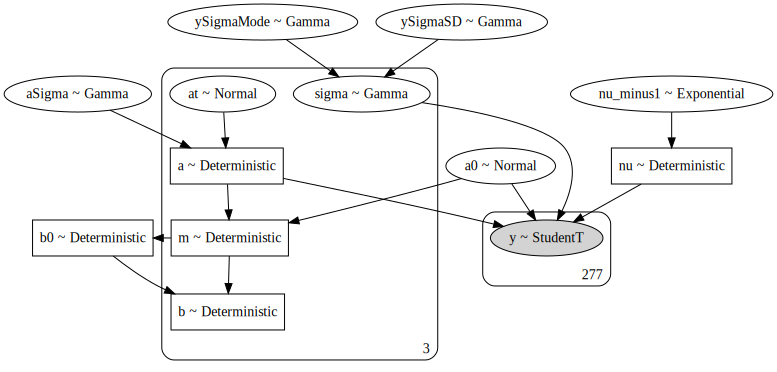

In [50]:
x = df.condition.cat.codes.values
y = df.response

yMean = y.mean()
ySD = y.std()

NxLvl = len(df.condition.cat.categories) # number of groups
aGammaShRa = gammaShRaFromModeSD(ySD/2, 2*ySD)

with pm.Model() as model3:
    
    aSigma = pm.Gamma('aSigma', aGammaShRa[0], aGammaShRa[1])
    a0 = pm.Normal('a0', yMean, tau=1/(ySD*10)**2)
    a_t = pm.Normal('at', mu=0, sd=1, shape=NxLvl)
#     a = pm.Normal('a', 0.0, tau=1/aSigma**2, shape=NxLvl)
    a = pm.Deterministic('a', 0.0 + aSigma * a_t) # reparameterization
    
    ySigmaSD = pm.Gamma('ySigmaSD', aGammaShRa[0], aGammaShRa[1])
    ySigmaMode = pm.Gamma('ySigmaMode', aGammaShRa[0], aGammaShRa[1])
    ySigmaRa = (ySigmaMode + np.sqrt(ySigmaMode**2 + 4*ySigmaSD**2))/2*ySigmaSD**2
    ySigmaSh = ySigmaMode*ySigmaRa
        
    ySigma = pm.Gamma('sigma', ySigmaSh, ySigmaRa, shape=NxLvl)
#     ySigma = pm.Deterministic('ySigma', tt.maximum(sigma, medianCellSD/1000))
    nu_minus1 = pm.Exponential('nu_minus1', 1/29.)
    nu = pm.Deterministic('nu', nu_minus1+1)
    like = pm.StudentT('y', nu=nu, mu=a0 + a[x], sd=ySigma[x], observed=y)
    
    # Convert a0,a to sum-to-zero b0,b 
    m = pm.Deterministic('m', a0 + a)
    b0 = pm.Deterministic('b0', tt.mean(m))
    b = pm.Deterministic('b', m - b0)

pm.model_to_graphviz(model3)

In [51]:
# with model3:
#     # Initializing NUTS with advi since jitter seems to create a problem in this model.
#     # https://github.com/pymc-devs/pymc3/issues/2897
# #     trace3 = pm.sample(3000, init='advi+adapt_diag', cores=4, nuts_kwargs={'target_accept': 0.95})
#     trace3 = pm.sample(20000,init='advi+adapt_diag', nuts_kwargs={'target_accept': 0.95} )
# #     trace3 = pm.sample(5000, nuts_kwargs={'target_accept': 0.95})

In [52]:
# import pickle

# # write
# with open('heterogenous-case.pkl', 'wb') as buff:
#     pickle.dump({'model': model3, 'trace': trace3}, buff)

# # read
# # with open('heterogenous-case.pkl', 'rb') as buff:
# #     data = pickle.load(buff)

# # model3, trace3 = data['model'], data['trace']

# no pickl
import os
tracefile = 'heterogenous-case.trace'
# pm.save_trace(trace3, directory=tracefile)

if not os.path.exists(tracefile):
    with model3:
        trace3 = pm.sample(
            20000, 
            init='advi+adapt_diag', 
            nuts_kwargs={'target_accept': 0.95})
    pm.save_trace(trace, directory=tracefile)
else:
    trace3 = pm.load_trace(tracefile, model=model3)

In [53]:
print(pm.diagnostics.gelman_rubin(trace3))
print("effective sample size", pm.diagnostics.effective_n(trace3))

{'a0': 1.000587383805425, 'at': array([1.00013138, 1.00007868, 1.00014981]), 'aSigma': 1.0003265283979033, 'a': array([1.00060686, 1.00060554, 1.00056757]), 'ySigmaSD': 1.0001740572638904, 'ySigmaMode': 1.0000495630887063, 'sigma': array([1.00004315, 1.00001069, 1.00007208]), 'nu_minus1': 1.0000073475701585, 'nu': 1.0000073475701585, 'm': array([0.99998494, 0.99998262, 0.99998732]), 'b0': 0.9999830105773441, 'b': array([0.9999826 , 0.99997999, 0.99999483])}
effective sample size {'a0': 8349.91736913788, 'at': array([21969.20105678, 21417.07388708, 21038.57198286]), 'aSigma': 10922.289737888468, 'a': array([8452.44877758, 8429.91440464, 8499.78036588]), 'ySigmaSD': 13042.865462719194, 'ySigmaMode': 20174.373834768176, 'sigma': array([43079.81925788, 43350.84481043, 29061.64840276]), 'nu_minus1': 57046.562995121174, 'nu': 57046.562995121174, 'm': array([85884.77008547, 76308.41552272, 68704.48525644]), 'b0': 78981.76473082267, 'b': array([88430.22493613, 77521.93255033, 64871.76766878])}

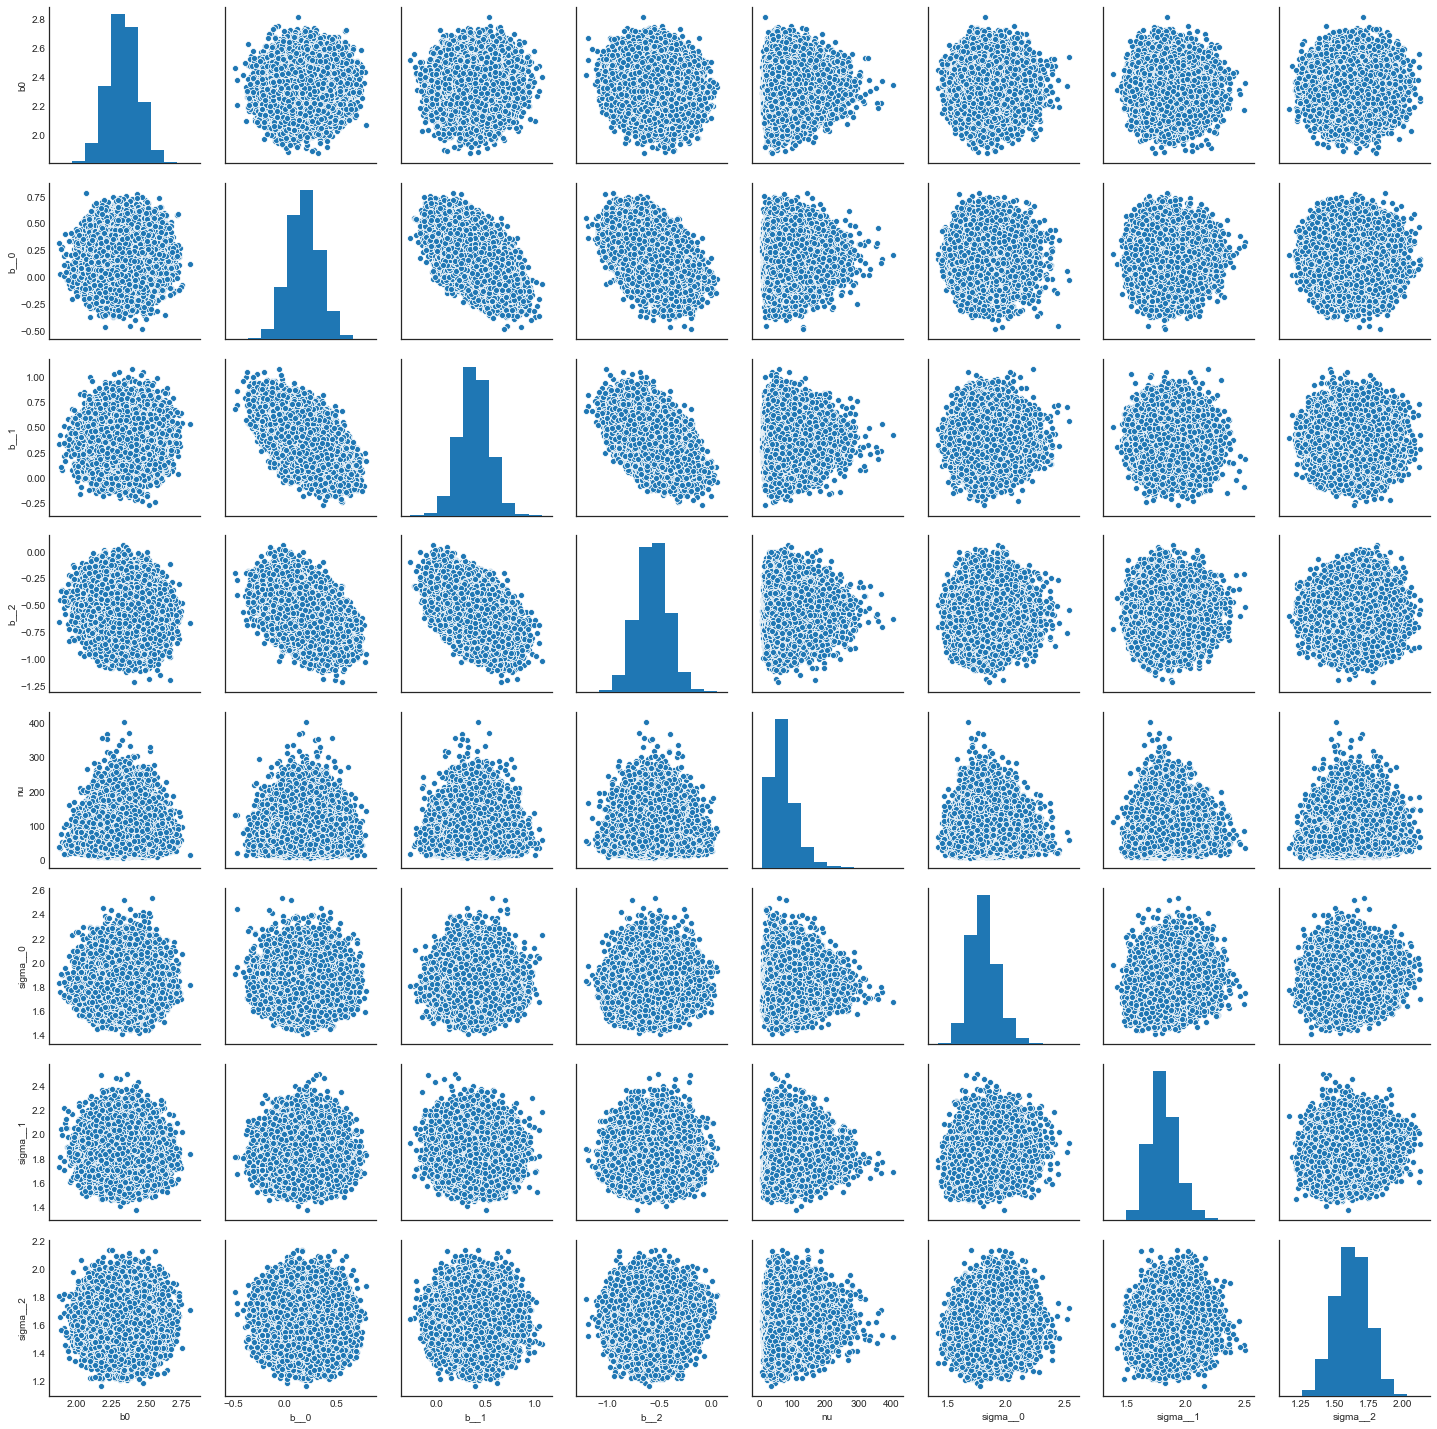

In [25]:
tracedf1 = pm.trace_to_dataframe(trace3, varnames=['b0', 'b', 'nu', 'sigma'])
sb.pairplot(tracedf1);

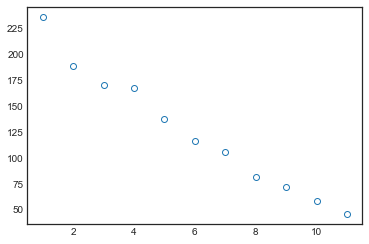

In [26]:
vals = np.array([model3.dict_to_array(v) for v in trace3[1000:]]).T
vals[:] -= vals.mean(axis=1)[:, None]
vals[:] /= vals.std(axis=1)[:, None]

U, S, Vh = linalg.svd(vals)
sb.mpl.pyplot.plot(np.arange(1, len(S)+1), S, 'o', mfc='w', mew=1)

## posterior predictive check

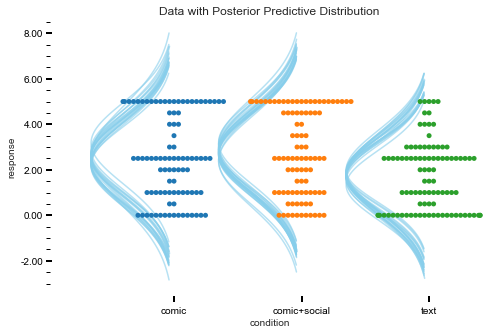

In [100]:
# Here we plot the metric predicted variable for each group. Then we superimpose the
# posterior predictive distribution

comic = trace3['m'][:, 0]
social = trace3['m'][:, 1]
text = trace3['m'][:, 2]
scale = trace3['sigma'][:]
d_f = trace3['nu']

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.set_title('Data with Posterior Predictive Distribution')

sb.swarmplot(
    'condition',
    'response',
    data=df,
    order=["comic", "comic+social", "text"], ax=ax)
ax.set_xlim(xmin=-1)


for i, grp in enumerate([comic, social, text]):
    sd = trace3['sigma'][:,i]
    # plotting mustaches with the student t; the original function uses a normal dist
    plot_mustache_studentT(var=grp, sd=sd, j=i, degree_f=d_f, axis=ax, width=0.65)

z = ax
z.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
z.tick_params(direction='in', length=6, width=2, colors='k', which='major')
z.tick_params(
    direction='in', length=4, width=1, colors='k', which='minor', bottom=False)
z.yaxis.set_ticks_position('left')
z.spines['right'].set_visible(False)
z.spines['top'].set_visible(False)
z.spines['left'].set_visible(False)
z.spines['bottom'].set_visible(False)
z.spines['bottom'].set_position(('outward', 10))

z.minorticks_on()

fig.savefig("data, with heterogenous varainces, robust, posterior predictions.pdf")

## contrasts

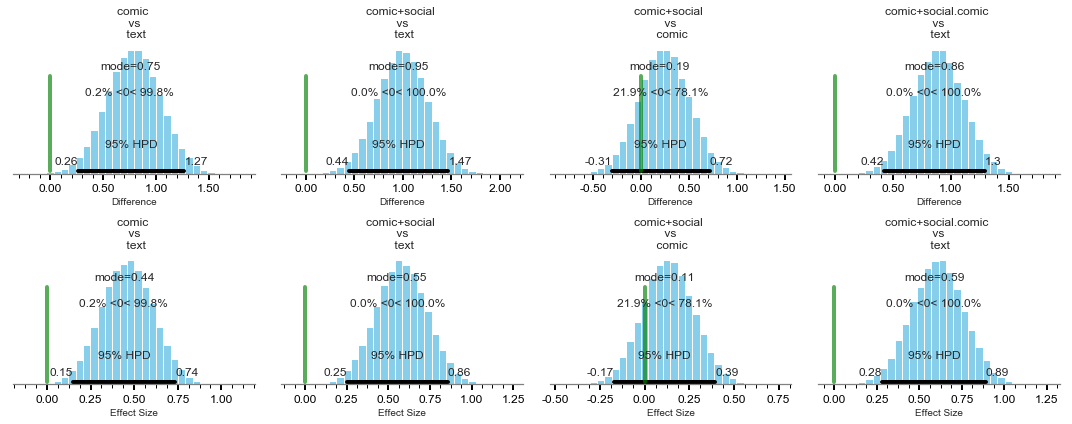

In [15]:
fig, axes = plt.subplots(2, 4, figsize=(15, 6))

comic = trace3['m'][:, 0]
social = trace3['m'][:, 1]
text = trace3['m'][:, 2]
scale = trace3['sigma'][:]

contrasts = [
    comic - text, 
    social - text, 
    social - comic,
    np.mean([comic, social], axis=0) - text
]

cscale = np.zeros((len(comic), 4))
cscale[:, 0] = np.sqrt((scale[:, 0]**2 + scale[:, 2]**2) / 2)  # comic, text
cscale[:, 1] = np.sqrt((scale[:, 1]**2 + scale[:, 2]**2) / 2)  # social, text
cscale[:, 2] = np.sqrt((scale[:, 1]**2 + scale[:, 0]**2) / 2)  # social, comic

t = np.sqrt((scale[:, 1]**2 + scale[:, 0]**2) / 4)  # variance of mean of comic and social
cscale[:, 3] = np.sqrt(
    (t**2 + scale[:, 2]**2) / 2)  # variance of mean of comic and social, text

sd = [cscale[:,0],
      cscale[:,1],
      cscale[:,2],
      cscale[:,3]
]

contrast_titles = [
    'comic \n vs \n text', 
    'comic+social \n vs \n text',
    'comic+social \n vs \n comic', 
    'comic+social.comic \n vs \n text'
]

for contr, csd, ctitle, ax_top, ax_bottom in zip(contrasts, sd, contrast_titles,
                                            fig.axes[:4], fig.axes[4:]):
    pm.plot_posterior(contr, ref_val=0, 
                      color=color, 
                      point_estimate='mode',
                      round_to=2,
                      ax=ax_top)
    pm.plot_posterior(contr / csd, ref_val=0, 
                      color=color, 
                      point_estimate='mode',
                      round_to=2,
                      ax=ax_bottom) # use this!!
#     pm.plot_posterior(contr, ref_val=0, color=color, ax=ax_bottom)
    ax_top.set_title(ctitle)
    ax_bottom.set_title(ctitle)
    
    ax_top.set_xlabel('Difference')
    ax_bottom.set_xlabel('Effect Size')
    
    ax_top.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax_bottom.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    
    ax_top.tick_params(direction='out', length=6, width=2, colors='k', which='major')
    ax_bottom.tick_params(direction='out', length=6, width=2, colors='k', which='major')
    
    ax_top.tick_params(direction='out', length=4, width=1, colors='k', which='minor')
    ax_bottom.tick_params(direction='out', length=4, width=1, colors='k', which='minor')
    
    ax_top.xaxis.set_ticks_position('bottom')
    ax_bottom.xaxis.set_ticks_position('bottom')
    
    ax_top.minorticks_on()
    ax_bottom.minorticks_on()
    
    
# z = axes
# z.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
# # z.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
# z.tick_params(direction='in', length=6, width=2, colors='k', which='major')
# z.tick_params(direction='in', length=4, width=1, colors='k', which='minor')
# z.xaxis.set_ticks_position('bottom')
# # z.yaxis.set_ticks_position('left')
# z.minorticks_on()

# fig.tight_layout()

fig.tight_layout()
fig.savefig("heterogenous variances, differences and effects, robust, case.pdf")

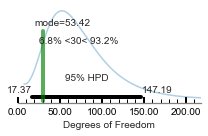

In [29]:
# checking normality

fig, axs = sb.mpl.pyplot.subplots(1, 1)  #### change on changing parameters
fig.set_size_inches(3, 2)

pm.plot_posterior(
    trace3['nu'],
    point_estimate='mode',
    kde_plot='True',
    round_to=2,
    ref_val=30,
    text_size=10,
    ax=axs)

z = axs
# s = "$\mu$"
z.set_xlabel("Degrees of Freedom")

center = trace3['nu'].mean()
z.set_xlim([0, 3*center])
z.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
# z.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
z.tick_params(direction='in', length=6, width=2, colors='k', which='major')
z.tick_params(direction='in', length=4, width=1, colors='k', which='minor')
z.xaxis.set_ticks_position('bottom')
# z.set_xscale('log')
# z.yaxis.set_ticks_position('left')
z.minorticks_on()

fig.tight_layout()
fig.savefig("normality parameter.pdf")


## traceplots

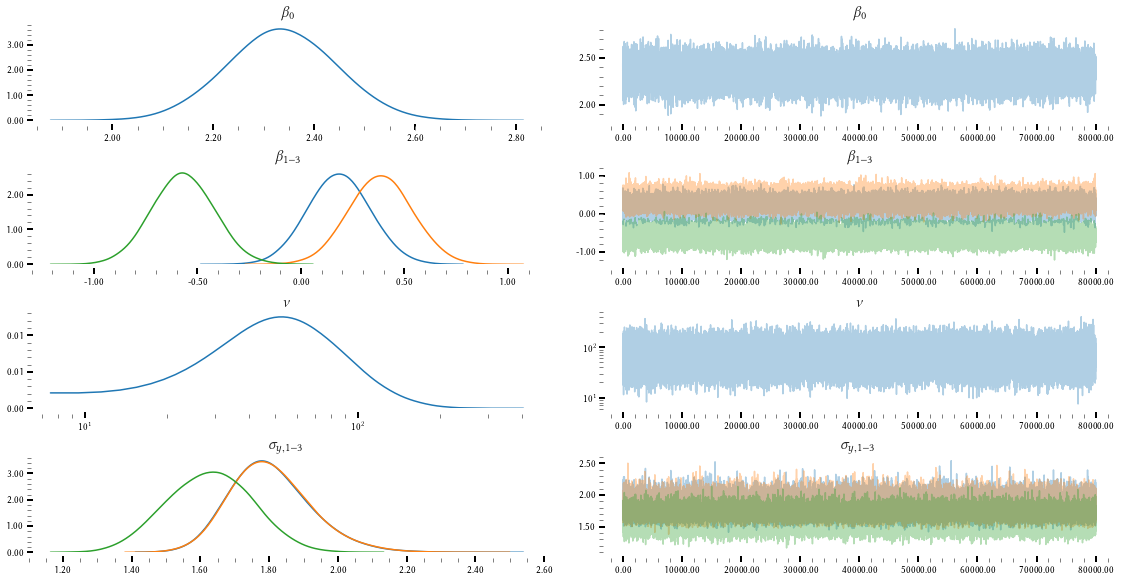

In [17]:
beta0 = trace3['b0']
beta1 = trace3['b'][:,0]
beta2 = trace3['b'][:,1]
beta3 = trace3['b'][:,2]

ysigma1 = trace3['sigma'][:,0]
ysigma2 = trace3['sigma'][:,1]
ysigma3 = trace3['sigma'][:,2]

# Use LaTeX for typesetting
rc('text', usetex=True)
# Use ACM standard fonts (Type 1) for numbers and labels
rc('text.latex',
   preamble=[
       r'\usepackage[tt=false, type1=true]{libertine}',
       r'\usepackage[libertine]{newtxmath}', 
       r'\usepackage[varqu]{zi4}',
       r'\usepackage[T1]{fontenc}'
   ])

NRows = 4 # four variables to show
NCols = 2
fig, axs = sb.mpl.pyplot.subplots(4, 2)

fig.set_size_inches(16, 8)


pm.traceplot(trace3, 
             varnames=['b0', 'b', 'nu', 'sigma'], 
             combined=True,
            ax=axs);

for i in range(NRows):
    for j in range(NCols):
        z = axs[i, j]
        z.set_xlabel("") # no individual labels
        z.set_ylabel("")
        z.spines['right'].set_visible(False)
        z.spines['top'].set_visible(False)
        z.spines['left'].set_visible(False)
        z.spines['bottom'].set_visible(False)
        z.spines['bottom'].set_position(('outward', 10))
        z.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        z.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        z.tick_params(direction='in', length=6, width=2, colors='k', which='major')
        z.tick_params(direction='in', length=4, width=1, colors='gray', which='minor')
        z.minorticks_on()

axs[2,0].set_xscale('log')
axs[2,1].set_yscale('log')

axs[0,0].set_title(r'$\beta_0$', size=16)
axs[0,1].set_title(r'$\beta_0$', size=16)
axs[1,0].set_title(r'$\beta_{1-3}$', size=16)
axs[1,1].set_title(r'$\beta_{1-3}$', size=16)
axs[2,0].set_title(r'$\nu$', size=16)
axs[2,1].set_title(r'$\nu$', size=16)
axs[3,0].set_title(r'$\sigma_{y, 1-3}$', size=16)
axs[3,1].set_title(r'$\sigma_{y, 1-3}$', size=16)

plt.subplots_adjust(hspace=0.5,
                    wspace=0.1)

fig.savefig('heterogenous variances, robust case, traceplot.pdf')

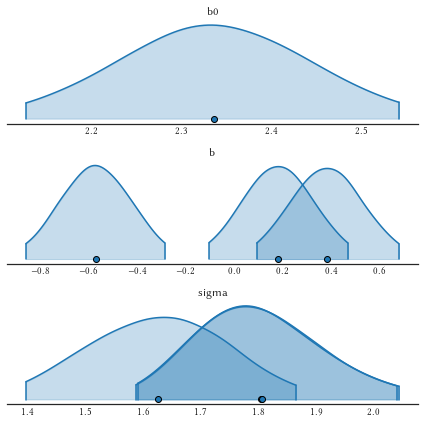

In [23]:
pm.densityplot(trace3, 
             varnames=['b0', 'b', 'sigma'], shade=0.25);